In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
from liftover import get_lifter
import seaborn as sns
import networkx as nx
import pickle
sys.path.append("/n/holystore01/LABS/liau_lab/Users/heejinroh/TDAC_seq/tdac_seq")
from ddda_dataset import *
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

In [2]:
# Create a folder to save plots
working_dir = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250"
plot_dir = os.path.join("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250/", "plot")
os.system("mkdir -p " + plot_dir)

# Create a dictionary for reference regions
ref_range_dict = {
    'HJR250_19': ('chr21', 38118238, 38127665)
}

# Initialize ddda_dataset
ddda_data = ddda_dataset(
    ID = "HJR_250_1_GM", 
    region_dict = ref_range_dict, 
    genome_file = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Genome/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna", 
    fastq_file =  "/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR250/HJR250_19/HJR250_19_merged.fastq.gz", 
    working_dir =  "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250"
)

# Load DddA bias model
with open("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/code/bias_dict.pkl", "rb") as f:
    ddda_data.bias_model = pickle.load(f)



Loading reference genome
Extracting sequences for each locus


In [3]:
def export_to_tsv(
        ddda_data, export_DddA_edit=True, export_del=False, 
        export_ABE_edit=False, export_strand=True, export_dir=None,
        overwrite=False
    ):
    '''
    Export key data slots in ddda_data to tsv files. This saves the read-by-position matrices such as the DddA
    edit matrix to a IJV COO matrix format (3 columns)
    '''

    for locus in ddda_data.ref_seq_dict:

        locus_str = "_".join(str(i) for i in ddda_data.region_dict[locus])
        if export_dir==None:
            export_dir=ddda_data.working_dir
        if not os.path.exists(export_dir):
            os.system("mkdir -p " + export_dir)
        
        if export_DddA_edit:
            print("Exporting DddA edits for dataset " + ddda_data.ID + " at locus " + locus)
            save_path = os.path.join(export_dir, ddda_data.ID + "_" + locus_str + "_DddA_edit_coo_mtx.tsv")
            if not os.path.exists(save_path) or overwrite:
                edit_coo_mtx = ddda_data.edit_dict[locus].tocoo()
                edit_df = pd.DataFrame({"i":edit_coo_mtx.row, "j":edit_coo_mtx.col, "v":edit_coo_mtx.data})
                edit_df.to_csv(save_path, sep="\t", index=None)
                
        if export_del:
            print("Exporting deletions for dataset " + ddda_data.ID + " at locus " + locus)
            save_path = os.path.join(export_dir, ddda_data.ID + "_" + locus_str + "_del_coo_mtx.tsv")
            if not os.path.exists(save_path) or overwrite:
                del_coo_mtx = ddda_data.del_dict[locus].tocoo()
                del_df = pd.DataFrame({"i":del_coo_mtx.row, "j":del_coo_mtx.col, "v":del_coo_mtx.data})
                del_df.to_csv(save_path, sep="\t", index=None)
                
        if export_ABE_edit:
            print("Exporting ABE edits for dataset " + ddda_data.ID + " at locus " + locus)
            save_path = os.path.join(export_dir, ddda_data.ID + "_" + locus_str + "_ABE_edit_coo_mtx.tsv")
            if not os.path.exists(save_path) or overwrite:
                ABE_edit_coo_mtx = ddda_data.ABE_edit_dict[locus].tocoo()
                ABE_edit_df = pd.DataFrame({"i":ABE_edit_coo_mtx.row, "j":ABE_edit_coo_mtx.col, "v":ABE_edit_coo_mtx.data})
                ABE_edit_df.to_csv(save_path, sep="\t", index=None)
                
        if export_strand:
            print("Exporting aligned reads for dataset " + ddda_data.ID + " at locus " + locus)
            save_path = os.path.join(export_dir, ddda_data.ID + "_" + locus_str + "_read_strands.tsv")
            if not os.path.exists(save_path) or overwrite:
                strand_df = pd.DataFrame({"strand":ddda_data.read_strands[locus]})
                strand_df.to_csv(save_path, sep="\t", index=None)

In [4]:
#export_to_tsv(
        ddda_data, export_DddA_edit=True, export_del=False, 
        export_ABE_edit=False, export_strand=True, export_dir=None,
        overwrite=False
    )

In [6]:
# Align reads
gap_threshold = 500
ddda_data.align_reads(
    start_gap_threshold = gap_threshold,
    end_gap_threshold = gap_threshold
)

100%|██████████| 46029/46029 [01:40<00:00, 459.32it/s]


18984 reads aligned. 27045 reads unaligned


In [7]:
locus = "HJR250_19"

In [38]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250/ddda_data_HJR250_19.pkl', 'wb') as f:
    pickle.dump(ddda_data , f)

In [4]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR250/ddda_data_HJR250_19.pkl', 'rb') as f:
    ddda_data = pickle.load(f)

In [8]:
min_num=8000
undel_read_ids=np.random.choice(np.array(ddda_data.read_ids[locus]), min_num, replace=False)

In [9]:
undel_read_ids = ddda_data.dedup_reads(
    locus = locus, 
    read_ids = undel_read_ids
)

100%|██████████| 8000/8000 [00:02<00:00, 3972.61it/s]
8000it [00:00, 1253527.79it/s]


In [10]:
undel_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in undel_read_ids])

In [11]:
selected_read_inds = undel_read_inds
selected_reads = np.array(ddda_data.read_ids[locus])[selected_read_inds]
selected_del_flags = np.zeros(len(undel_read_inds))
selection_dict = {"HJR250_19":selected_reads}

In [24]:
strands =ddda_data.read_strands[locus][selected_read_inds]
CtoT_inds = selected_read_inds[strands==0]
GtoA_inds = selected_read_inds[strands==1]

CtoT_reads=np.array(ddda_data.read_ids[locus])[CtoT_inds]
GtoA_reads=np.array(ddda_data.read_ids[locus])[GtoA_inds]

CtoT_edits = np.array(ddda_data.edit_dict[locus][CtoT_inds, :].todense())
GtoA_edits = np.array(ddda_data.edit_dict[locus][GtoA_inds, :].todense())
edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())

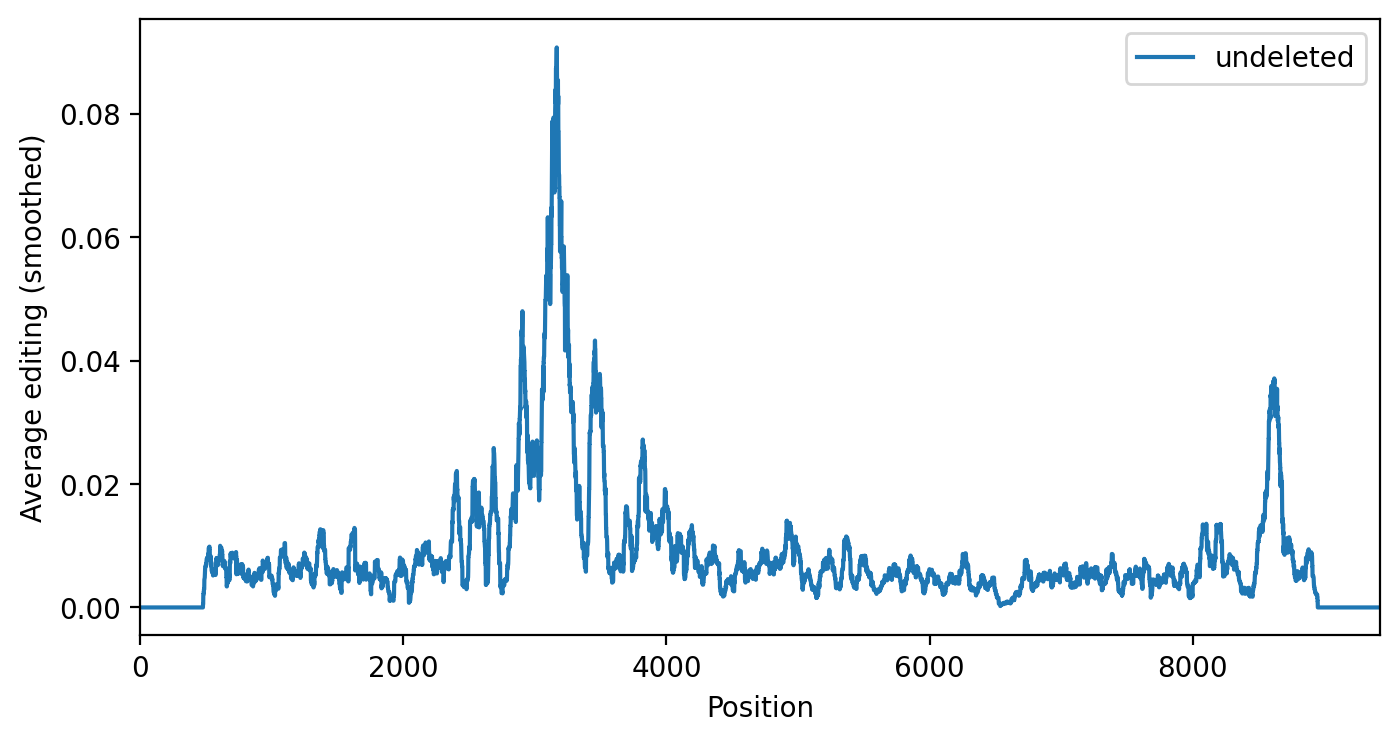

In [25]:
# Calculate average editing rate for each condition
track_undeleted_ac = np.mean(edits[np.array(selected_del_flags) == 0, :], axis = 0)

# Smooth tracks
track_undeleted_ac_smoothed = np.convolve(track_undeleted_ac, np.ones(50),mode='same')/50

# Visualize results
plt.figure(dpi=200, figsize=(8, 4))

plt.plot(np.arange(len(track_undeleted_ac_smoothed)), track_undeleted_ac_smoothed, label="undeleted")
plt.xlabel("Position")
plt.ylabel("Average editing (smoothed)")
plt.legend()
plt.xlim(0, len(track_undeleted_ac_smoothed) - 1)

plt.show()

In [14]:
from matplotlib.colors import ListedColormap, BoundaryNorm
base_colors_blue = plt.cm.Blues(np.linspace(0, 1, 256))
base_colors_blue[0] = [0.97, 0.97, 0.97, 1]  # 첫 번째 색상을 밝은 회색으로 변경
base_colors_blue[-1] = [0, 0, 0.5, 1]  # 마지막 색상을 더 어두운 파란색으로 변경
custom_cmap_blue = ListedColormap(base_colors_blue)

base_colors_red = plt.cm.Reds(np.linspace(0, 1, 256))
base_colors_red[0] = [0.97, 0.97, 0.97, 1]  # 첫 번째 색상을 밝은 회색으로 변경
base_colors_red[-1] = [0.5, 0, 0, 1]  # 마지막 색상을 더 어두운 빨간색으로 변경
custom_cmap_red = ListedColormap(base_colors_red)

base_colors_purple = plt.cm.Purples(np.linspace(0, 1, 256))
base_colors_purple[0] = [0.97, 0.97, 0.97, 1]  # Change the first color to light gray
base_colors_purple[-1] = [0.25, 0, 0.5, 1]  # Change the last color to a darker purple
custom_cmap_purple = ListedColormap(base_colors_purple)

In [15]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/bedgraph_data_K562_ATAC.pkl', 'rb') as f:
    bedgraph_data = pickle.load(f)
    
filtered_data = bedgraph_data[(bedgraph_data['chrom'] == ref_range_dict[locus][0]) &
                              (bedgraph_data['start'] >= ref_range_dict[locus][1]) &
                              (bedgraph_data['start'] <= ref_range_dict[locus][2])]

all_positions = pd.DataFrame({'start': np.arange(38118238, 38127666)})

# Merging with the filtered data, filling missing values with zero
merged_data = pd.merge(all_positions, filtered_data, on='start', how='left').fillna(0)

ATAC_x_values = merged_data['start']
ATAC_y_values = merged_data['value'].values



In [16]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/bedgraph_data_K562_H3K27ac.pkl', 'rb') as f:
    bedgraph_data = pickle.load(f)

filtered_data = bedgraph_data[(bedgraph_data['chrom'] == ref_range_dict[locus][0]) &
                              (bedgraph_data['start'] >= ref_range_dict[locus][1]) &
                              (bedgraph_data['start'] <= ref_range_dict[locus][2])]

all_positions = pd.DataFrame({'start': np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)})

# Merging with the filtered data, filling missing values with zero
merged_data = pd.merge(all_positions, filtered_data, on='start', how='left').fillna(0)

H3K27ac_x_values = merged_data['start']
H3K27ac_y_values = merged_data['value'].values

In [17]:
with open('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/bedgraph_data_K562_H3K4me3.pkl', 'rb') as f:
    bedgraph_data = pickle.load(f)
    
filtered_data = bedgraph_data[(bedgraph_data['chrom'] == ref_range_dict[locus][0]) &
                              (bedgraph_data['start'] >= ref_range_dict[locus][1]) &
                              (bedgraph_data['start'] <= ref_range_dict[locus][2])]

all_positions = pd.DataFrame({'start': np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)})

# Merging with the filtered data, filling missing values with zero
merged_data = pd.merge(all_positions, filtered_data, on='start', how='left').fillna(0)

H3K4me3_x_values = merged_data['start']
H3K4me3_y_values = merged_data['value'].values

In [18]:
ATAC_x_values_plot = ATAC_x_values[500:-500]
ATAC_y_values_plot = ATAC_y_values[500:-500]

H3K27ac_x_values_plot = H3K27ac_x_values[500:-500]
H3K27ac_y_values_plot = H3K27ac_y_values[500:-500]

H3K4me3_x_values_plot = H3K4me3_x_values[500:-500]
H3K4me3_y_values_plot = H3K4me3_y_values[500:-500]


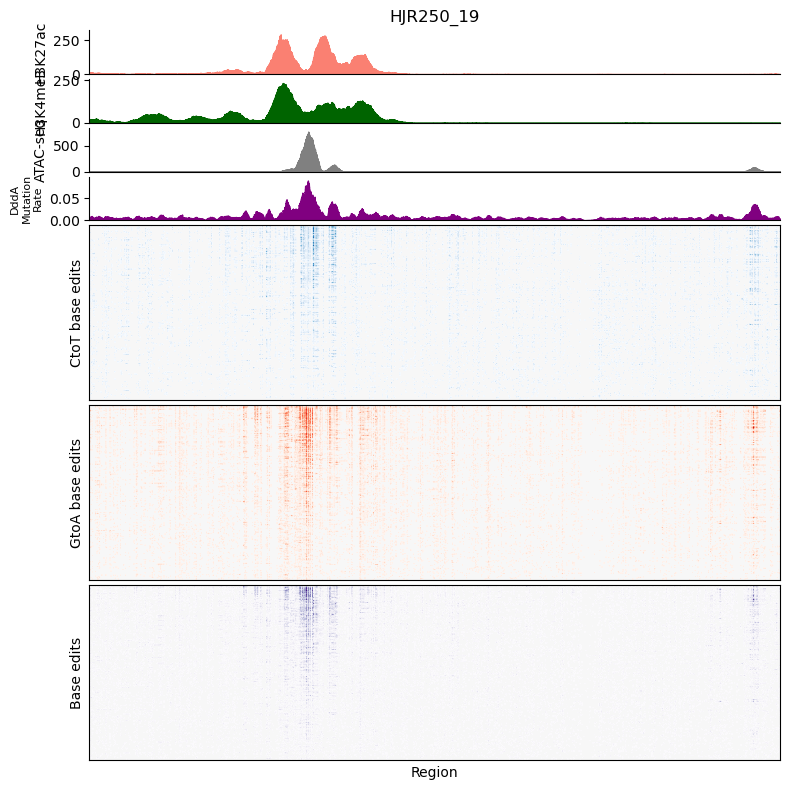

In [40]:
import matplotlib.gridspec as gridspec
plot_range= np.arange(500, 38127666-38118238-500)
fig = plt.figure(figsize=(8, 8))  # Adjusted the figure size to accommodate four plots
gs = gridspec.GridSpec(7, 1, height_ratios=[0.5, 0.5, 0.5, 0.5, 2, 2,2])  # Adjusted to four rows

ax0 = plt.subplot(gs[0])
ax0.fill_between(H3K27ac_x_values_plot, H3K27ac_y_values_plot, color='salmon', alpha=1)
ax0.set_xlim([H3K27ac_x_values_plot.min(), H3K27ac_x_values_plot.max()])
ax0.set_ylim([0, max(H3K27ac_y_values_plot) * 1.1])
ax0.set_xticks([])  # Remove x-axis ticks
ax0.set_xlabel('')
ax0.set_ylabel('H3K27ac')
ax0.set_title('HJR250_19')

# Remove box outline and keep x and y axis
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)

ax1 = plt.subplot(gs[1])
ax1.fill_between(H3K4me3_x_values_plot, H3K4me3_y_values_plot, color='darkgreen', alpha=1)
ax1.set_xlim([H3K4me3_x_values_plot.min(), H3K4me3_x_values_plot.max()])
ax1.set_ylim([0, max(H3K4me3_y_values_plot) * 1.1])
ax1.set_xticks([])  # Remove x-axis ticks
ax1.set_xlabel('')
ax1.set_ylabel('H3K4me3')

# Remove box outline and keep x and y axis
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)


# New plot (Top plot)
ax2 = plt.subplot(gs[2])
ax2.fill_between(ATAC_x_values_plot, ATAC_y_values_plot, color='Grey', alpha=1)
ax2.set_xlim([ATAC_x_values_plot.min(), ATAC_x_values_plot.max()])
ax2.set_ylim([0, max(ATAC_y_values_plot) * 1.1])
ax2.set_xticks([])  # Remove x-axis ticks
ax2.set_xlabel('')
ax2.set_ylabel('ATAC-seq')

# Remove box outline and keep x and y axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# First subplot (now second)
ax3 = plt.subplot(gs[3])
x_values = np.arange(len(track_undeleted_ac_smoothed[plot_range]))
ax3.fill_between(x_values, track_undeleted_ac_smoothed[plot_range], color='purple', alpha=1)
ax3.set_xlim([x_values.min(), x_values.max()])
ax3.set_ylim([0, max(track_undeleted_ac_smoothed[plot_range]) * 1.1])
ax3.set_xticks([])  # Remove x-axis ticks
ax3.set_xlabel('')
ax3.set_ylabel('DddA\nMutation\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

CtoT_edits = np.array(ddda_data.edit_dict[locus][CtoT_inds, :].todense())
read_edit_num = np.sum(CtoT_edits, axis=1)
row_order = [i for i in np.argsort(-read_edit_num)]

# Second subplot (now third)
ax4 = plt.subplot(gs[4])
ax4.imshow(CtoT_edits[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0, cmap=custom_cmap_blue)
ax4.set_ylabel('CtoT base edits')
ax4.set_xticks([])  # Remove x-axis ticks
ax4.set_yticks([])  # Remove y-axis ticks
ax4.set_xlabel('')

GtoA_edits = np.array(ddda_data.edit_dict[locus][GtoA_inds, :].todense())
read_edit_num = np.sum(GtoA_edits, axis=1)
row_order = [i for i in np.argsort(-read_edit_num)]

# Third subplot (now fourth)
ax5 = plt.subplot(gs[5])
ax5.imshow(GtoA_edits[row_order, :][:, plot_range], aspect='auto', vmax=0.7, vmin=0,  cmap=custom_cmap_red)
ax5.set_xlabel('Region')
ax5.set_ylabel('GtoA base edits')
ax5.set_xticks([])  # Remove x-axis ticks
ax5.set_yticks([])  # Remove y-axis ticks


edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
read_edit_num = np.sum(edits, axis=1)
row_order = [i for i in np.argsort(-read_edit_num)]

ax6 = plt.subplot(gs[6])
ax6.imshow(edits[row_order, :][:, plot_range], aspect='auto', vmax=0.5, vmin=0, cmap=custom_cmap_purple)
ax6.set_xlabel('Region')
ax6.set_ylabel('Base edits')
ax6.set_xticks([])  # Remove x-axis ticks
ax6.set_yticks([])  # Remove y-axis ticks


plt.tight_layout()  # Adjust layout
plt.subplots_adjust(hspace=0.05)  # Adjust space between plots

plt.savefig('HJR250_19_includemighmut_0.5max.pdf', format='pdf')

plt.show()